In [1]:
import numpy as np
import os
import pickle
import pandas as pd
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image 
from numpy import linalg as LA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Data Preprocessing

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6

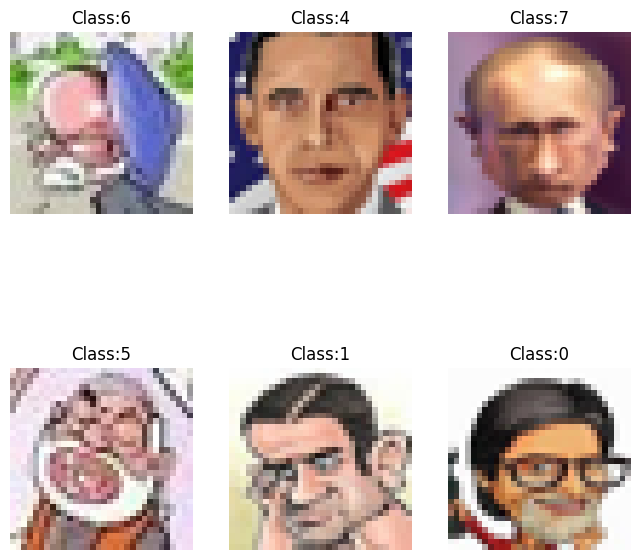

In [8]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list


dirpath = 'IIIT-CFW'
X,y = load_data(dirpath)
Z = X.reshape(X.shape[0], -1)
person_labels = y
print(y)
print(Z.shape)
# print(Z[0][31])
# [[[a,b,c]....32 times]...32 times]
N,H,W = X.shape[0:3]
# print(N,H,W)
C = 1 if opt['is_grayscale'] else X.shape[3]
ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

Implementation of Principle Component Analysis

shape (3072, 3072)
[0.33621194 0.41963403 0.47370082 ... 1.         1.         1.        ]


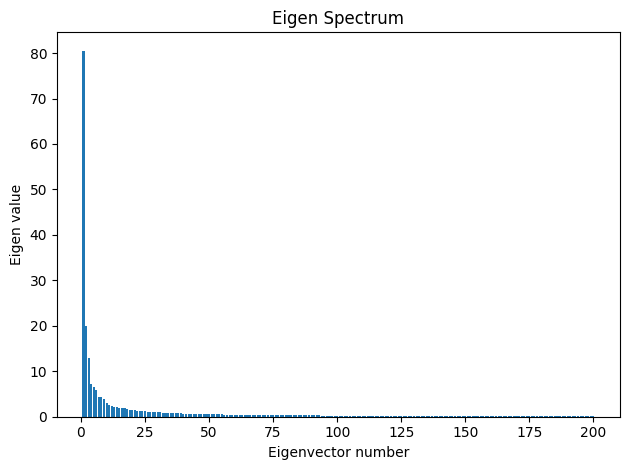

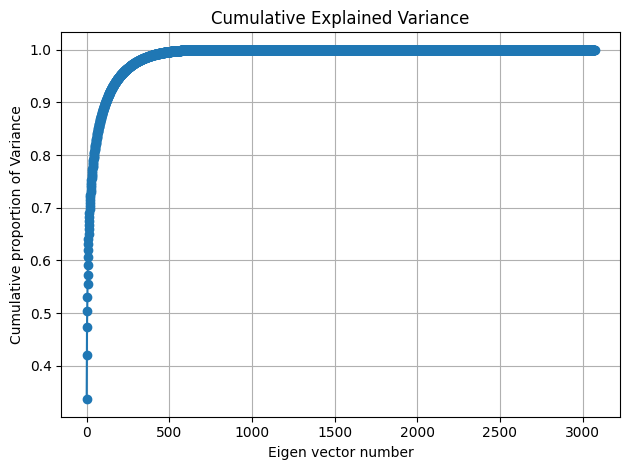

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3072, 672)


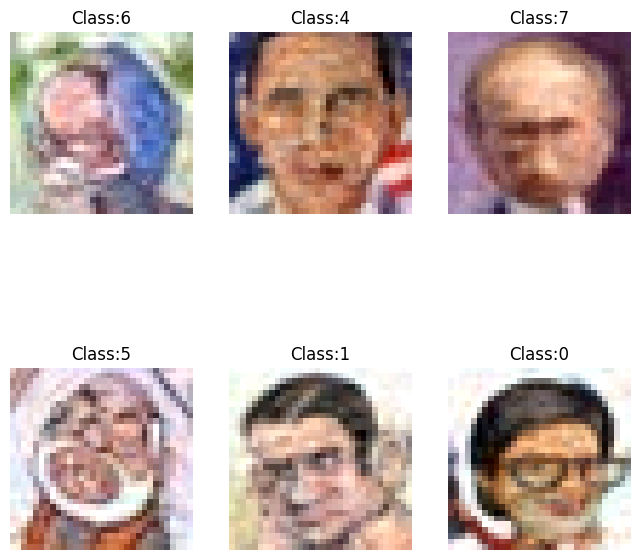

In [15]:
# class sklearn.decomposition.PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

# Assume that we start with a data set that is represented in terms of an m × n matrix, X ; where the n columns are the samples (e.g. observations) and the m rows are the variables
class PCA:
    def __init__(self,n_components_=None,components_ = None,mean_=None,explained_variance_ratio_=None):
        self.n_components_ = n_components_ # The estimated number of components
        self.components_ = components_ # ndarray of shape (n_components, n_features)
        self.mean_ = mean_ # ndarray of shape (n_features,) Per-feature empirical mean, estimated from the training set.
        self.explained_variance_ratio_ = explained_variance_ratio_

    def set_n_components_(self,n_components_):
        self.n_components_ = n_components_ # The estimated number of components

    def fit(self,X):
        # Shape of X is (672,32,32,3) , Now  we convert it into 3072*672 matrix
        num_samples = X.shape[0]
        T = (X.reshape(num_samples,-1)).T
        # print(T.shape)
        mean = np.mean(T,axis=1) # calculates mean along columns in a single row
        self.mean_ = mean
        # Suppose we have a vector of n discrete measurements, r̃ = (r̃1 ,r̃2 , . . . , r̃n), with mean µr .If we subtract the mean from each of the measurements, then we obtain a translated set of measurements r = (r1 ,r2 , . . . , rn), that has zero mean.
        X_centered = T-mean.reshape(-1,1) 
        Z = X_centered.T/np.sqrt(num_samples-1)
        # Covariance can be thought of as a measure of how much two variables change together. Variance is thus a special case of covariance, when the the two variables are identical.
        C = (Z.T@Z)
        # print(num_samples)
        eigenvalues, eigenvectors = LA.eigh(C) # Return the eigenvalues and eigenvectors of a complex Hermitian (conjugate symmetric) or a real symmetric matrix , matrix deals with XX^T
        sorted_indices = np.argsort(-eigenvalues)
        self.eigen_values = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        self.components_ = eigenvectors
        print('shape',self.components_.shape)
        total_variance = np.sum(self.eigen_values)
        # print(total_variance)
        self.explained_variance_ratio_ = np.cumsum(self.eigen_values/total_variance)

    def transform(self,X):
        if self.mean_ is None:
            raise ValueError("Mean is not Defined.")
        if self.components_ is None:
            raise ValueError("Eigen Vectors are Not Defined.")
        num_samples = X.shape[0]
        T = (X.reshape(num_samples,-1)).T
        # print(T.shape)
        mean = np.mean(T,axis=1) # calculates mean along columns in a single row
        # Suppose we have a vector of n discrete measurements, r̃ = (r̃1 ,r̃2 , . . . , r̃n), with mean µr .If we subtract the mean from each of the measurements, then we obtain a translated set of measurements r = (r1 ,r2 , . . . , rn), that has zero mean.
        X_centered = T-mean.reshape(-1,1) 
        reduced_data = self.components_[:, :self.n_components_].T @ X_centered
        return reduced_data

    def eigen_spectrum(self,num_components = None):
        # print(self.eigen_values)
        print(self.explained_variance_ratio_)
        if num_components is None:
            num_components = self.n_components_
        top_eigen_values = self.eigen_values[:num_components]
        plt.bar(range(1,1+num_components),top_eigen_values)
        plt.xlabel('Eigenvector number')
        plt.ylabel('Eigen value')
        plt.title('Eigen Spectrum')
        plt.tight_layout()
        plt.show()
        
    def plot_cumulative_variance(self):
        plt.plot(np.arange(1, len(self.explained_variance_ratio_) + 1), self.explained_variance_ratio_, marker='o')
        plt.xlabel('Eigen vector number')
        plt.ylabel('Cumulative proportion of Variance')
        plt.title('Cumulative Explained Variance')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def image_compression(self,X):
        if self.components_ is None:
            raise ValueError("Eigen Vectors are Not Defined")
        VV = self.components_[:, :self.n_components_]
        num_samples = X.shape[0]
        T = (X.reshape(num_samples,-1)).T
        # print(T.shape)
        mean = np.mean(T,axis=1)
        # Suppose we have a vector of n discrete measurements, r̃ = (r̃1 ,r̃2 , . . . , r̃n), with mean µr .If we subtract the mean from each of the measurements, then we obtain a translated set of measurements r = (r1 ,r2 , . . . , rn), that has zero mean.
        X_centered = T-mean.reshape(-1,1) 
        Y = VV.T@X_centered
        XX = VV@Y
        return XX+self.mean_.reshape(-1,1) 
    
    
        

n_components = 200
pca = PCA(200)
pca.fit(X)
pca.eigen_spectrum()
pca.plot_cumulative_variance()
compressed_X = pca.image_compression(X)
print(compressed_X.shape)
new_image = compressed_X.T
compressed_image = new_image.reshape(672,32,32,3)
display_images(compressed_image[ind,...],y[ind], row=2,col=3)

# Dimensionality reduction on features that were used for Pictionary Dataset

1500
shape (512, 512)


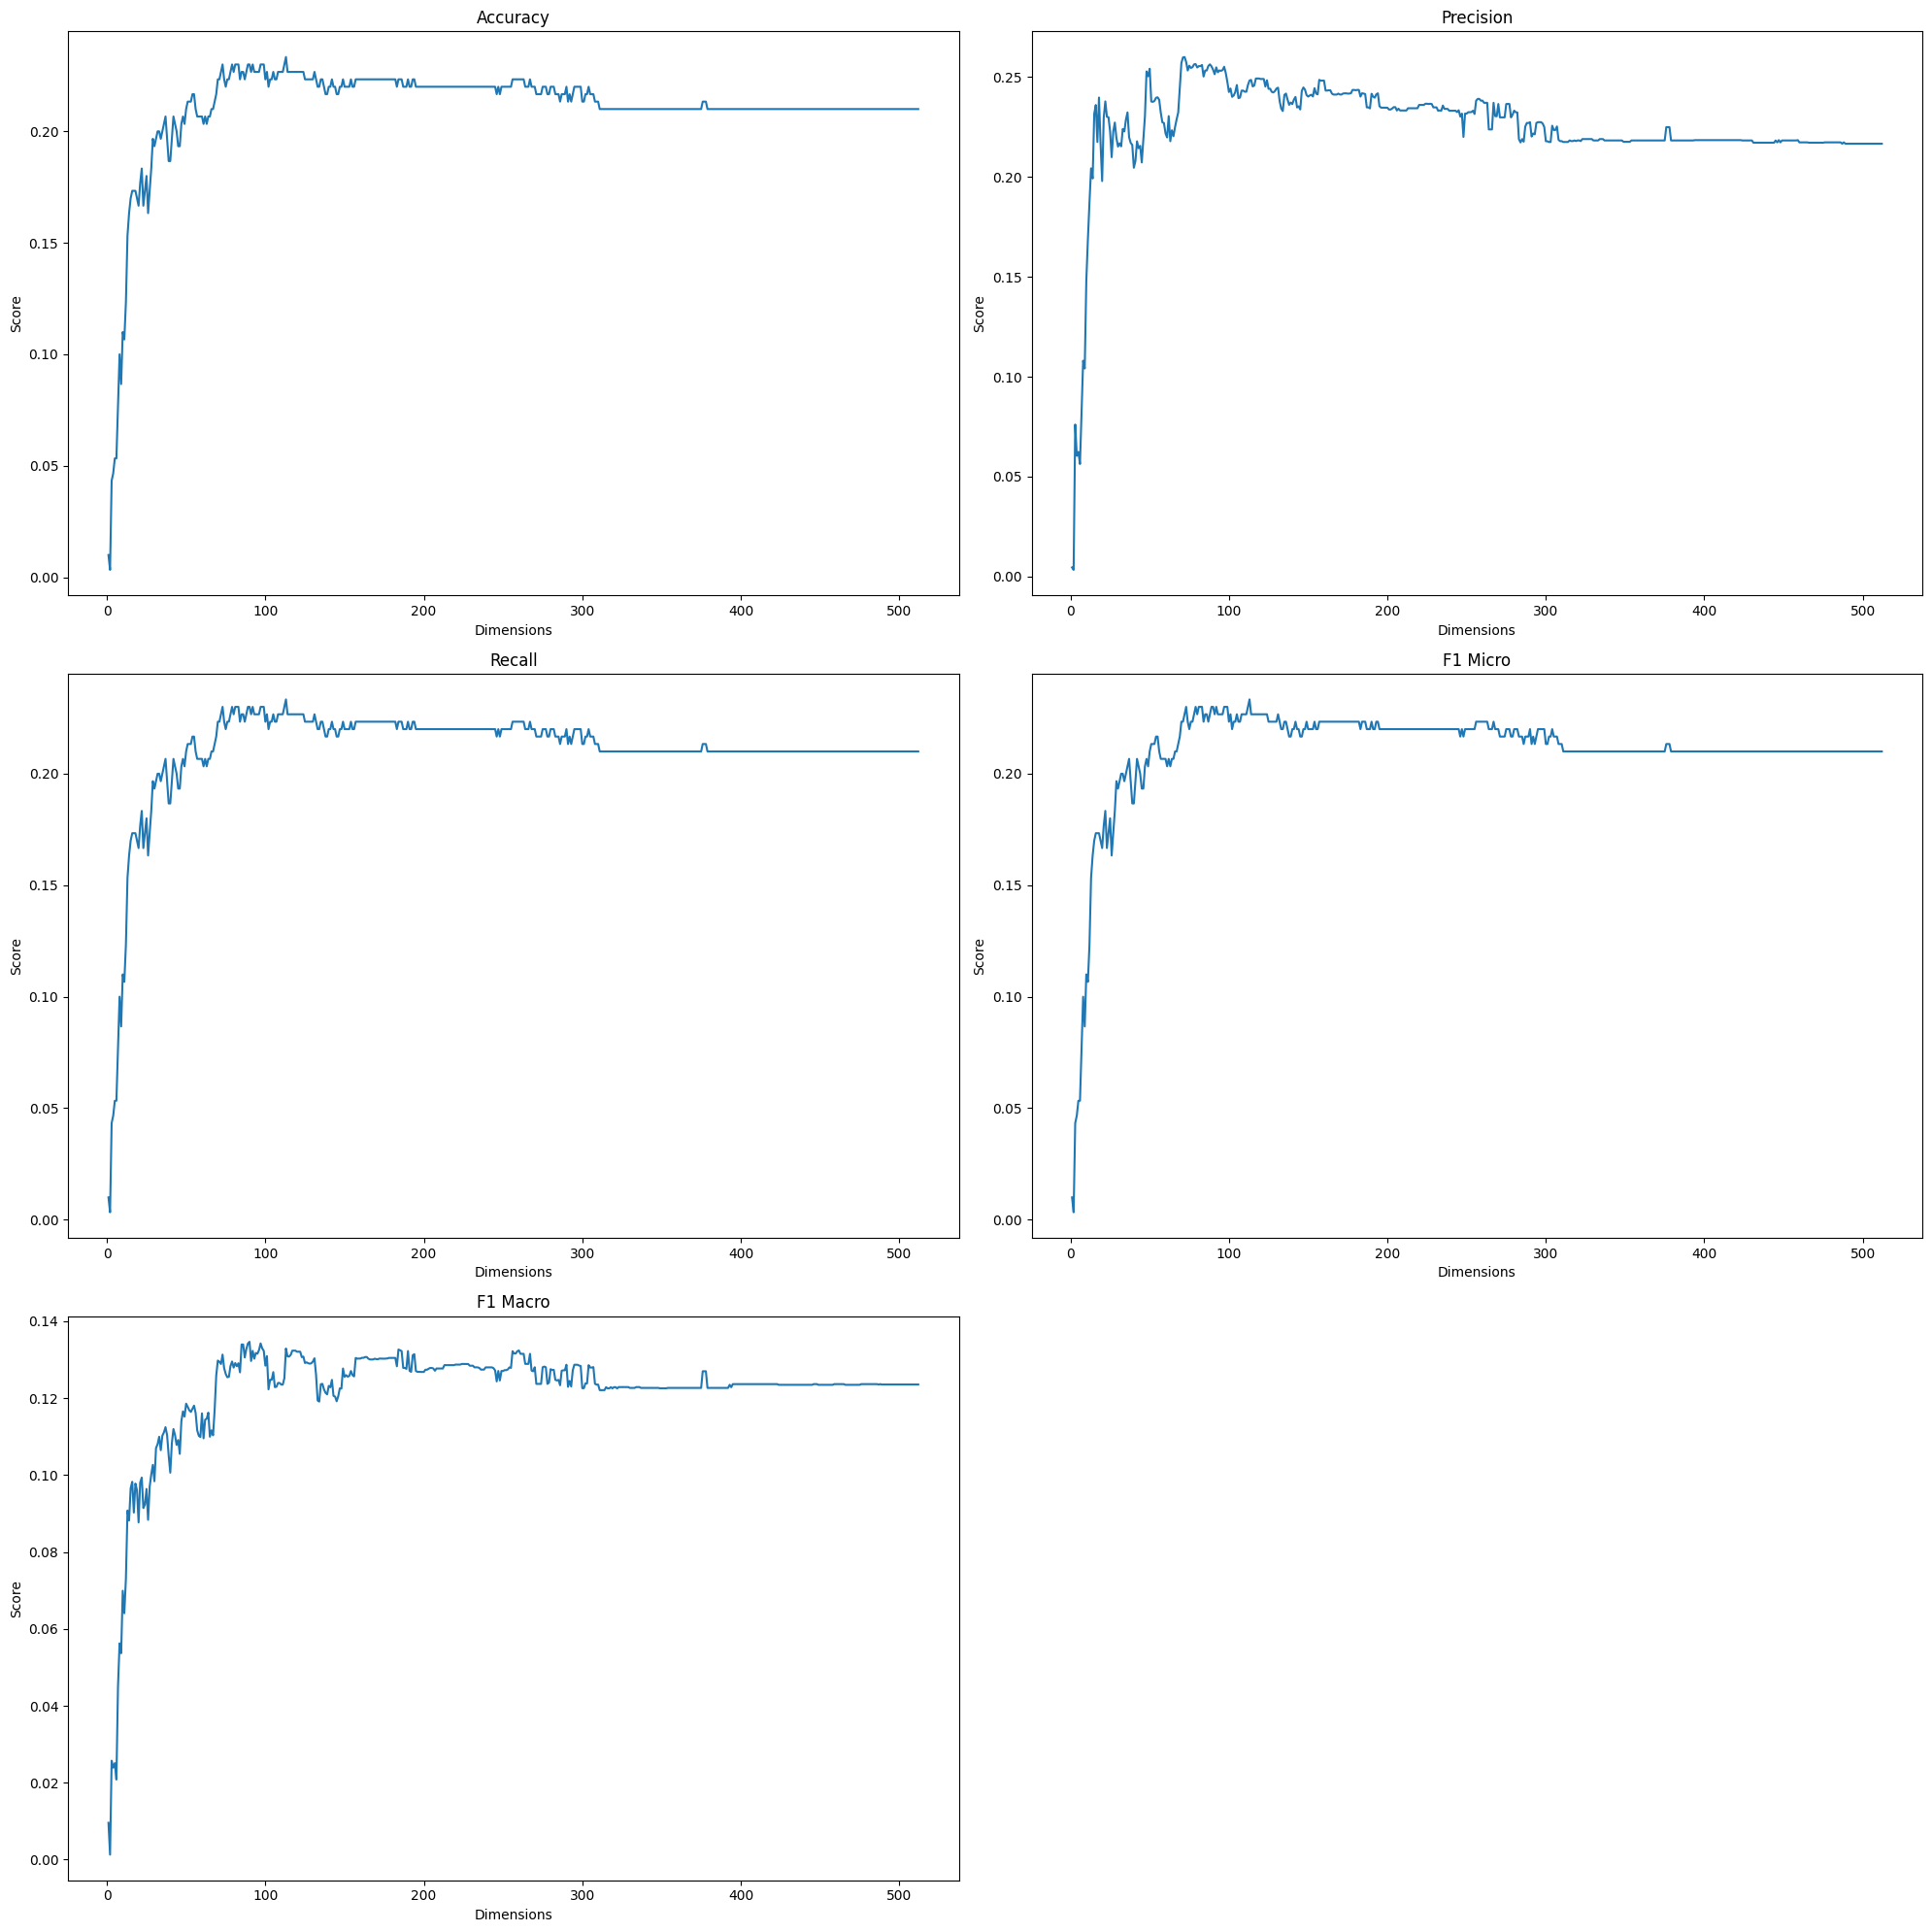

In [5]:
data = np.load('data.npy', allow_pickle=True)
# game_id , resnet(1 x 1024) , vit (1 x 512) , label_name , guess time
resnet = np.array([res[0] for res in np.array(data[:,1])])
vit = np.array([v[0] for v in np.array(data[:,2])])
# print(vit.shape)
data_labels = np.array(data[:, 3])
# print(transformed_vit.shape)
X_data = vit
y_data = data_labels
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,test_size=0.2, random_state=42) 
dimensions = list(range(1, 513))
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_micro_scores = []
f1_macro_scores = []
num_features = X_data.shape[0]
print(num_features)
pca = PCA(num_features)
pca.fit(vit)
KNN = KNeighborsClassifier()
for num_components in dimensions:
    pca.set_n_components_(num_components)
    transformed_X_train = pca.transform(X_train)
    transformed_X_test = pca.transform(X_test)
    KNN.fit(transformed_X_train.T,y_train)
    y_pred = KNN.predict(transformed_X_test.T)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_micro_scores.append(f1_micro)
    f1_macro_scores.append(f1_macro)

# Create separate plots for each metric
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 1)
plt.plot(dimensions, accuracy_scores)
plt.title('Accuracy')
plt.xlabel('Dimensions')
plt.ylabel('Score')

plt.subplot(3, 2, 2)
plt.plot(dimensions, precision_scores)
plt.title('Precision')
plt.xlabel('Dimensions')
plt.ylabel('Score')

plt.subplot(3, 2, 3)
plt.plot(dimensions, recall_scores)
plt.title('Recall')
plt.xlabel('Dimensions')
plt.ylabel('Score')

plt.subplot(3, 2, 4)
plt.plot(dimensions, f1_micro_scores)
plt.title('F1 Micro')
plt.xlabel('Dimensions')
plt.ylabel('Score')

plt.subplot(3, 2, 5)
plt.plot(dimensions, f1_macro_scores)
plt.title('F1 Macro')
plt.xlabel('Dimensions')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# 📊 **Observations**
```
In our experiment, we embarked on a journey with a dataset comprising 512 components, employing advanced machine learning techniques to train a model. We meticulously scrutinized various performance metrics, including accuracies, F1 micros, F1 macros, precisions, and recalls.
```
## 🚀 **Initial Rapid Improvement**
```
A remarkable observation unfolded as the model rapidly surged in performance within the initial 100 epochs. During this phase, the model swiftly adapted to the dataset's intricacies, resulting in substantial enhancements across multiple metrics.

- Accuracies: Initially, we witnessed a meteoric rise, underscoring the model's exceptional precision in making accurate predictions.

- F1 Micro scores and F1 Macro scores: These F1 scores followed a similar trajectory to accuracies, showcasing the model's prowess in achieving a harmonious balance between precision and recall.

- Precisions and Recalls: Both precision and recall metrics exhibited behaviors in lockstep with the F1 scores, emphasizing the model's remarkable ability to effectively manage false positives and false negatives. 
```


## ⏳ **Plateauing Performance**
```
However, as the experiment progressed beyond approximately 100 epochs, a notable transformation in the metrics' behavior emerged. All metrics seemed to plateau, maintaining relative stability without substantial improvements.
```

## 🔍 **Conclusion:** 
```
The model adeptly grasped the dataset's nuances, achieving a high level of performance early on. The plateauing trend observed after around 100 epochs implies that further training did not yield significant performance enhancements. Our model reached a point of diminishing returns in terms of training epochs. By recognizing the point of diminishing returns in training epochs, we can optimize computational resources and strive for more efficient and effective machine learning models.
```

## 💡 **Implications and Recommendations**
```
These observations have significant implications for our model training strategy:

- 🔌 Efficient Training: Given the rapid initial improvement and subsequent plateau, it is advisable to implement early stopping mechanisms. This prudent approach can help conserve valuable computational resources and mitigate the risk of overfitting.

- 🎯 Hyperparameter Tuning: To attain more substantial performance gains, it is recommended to delve into hyperparameter tuning and architectural adjustments. This strategic approach holds the potential to outperform mere incrementation of training epochs.
```

# Observing Impact of Dimensionality reduction on features that were used for IIITH-CFW Dataset

3072
shape (3072, 3072)
3072


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


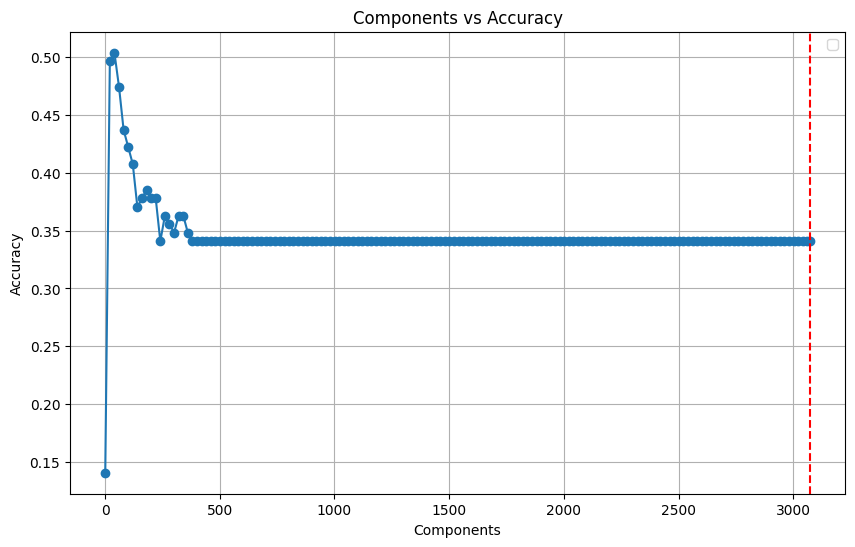

In [22]:
num_features = Z.shape[1]
# num_features = 20
print(num_features)
pca = PCA(num_features)
pca.fit(X)
X_data_IIITH = Z
y_data_IIITH = person_labels
X_train, X_test, y_train, y_test = train_test_split(X_data_IIITH,y_data_IIITH,test_size=0.2, random_state=42) 
KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_test)
full_dimension_accuracy = accuracy_score(y_test,y_pred)
# print(full_dimension_accuracy)
accuracy_list = []
print(num_features)
# Modify the code to iterate for every 25 values
for num_components in range(1, num_features + 1, 20):
    pca.set_n_components_(num_components)
    transformed_X_train = pca.transform(X_train)
    transformed_X_test = pca.transform(X_test)
    KNN.fit(transformed_X_train.T, y_train)
    y_pred = KNN.predict(transformed_X_test.T)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

# Add full dimension accuracy (3072 components) to the array
accuracy_list.append(full_dimension_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(list(range(1, num_features + 1, 20))+[num_features], accuracy_list, marker='o')
plt.axvline(x=num_features, color='r', linestyle='--')
plt.legend()
plt.title('Components vs Accuracy')
plt.xlabel('Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 1.2 - Pictionary Dataset

In [ ]:
draw_data = pd.read_csv('pictionary/drawer_attributes.csv') # reading data # 100 rows x 9 columns
guess_data = pd.read_csv('pictionary/guesser_attributes.csv') # 100 rows x 7 columns
display(draw_data)
display(guess_data)
X_draw = np.array(draw_data)
# print(X_draw)
X_guess = np.array(guess_data)
features_draw = ['Drawer_ID','Area','Frequency','Duration','FirstStroke','LastStroke','Thumbsup','Thumbsdown','Erase']
features_guess = ['Guesser_ID','num_guesses','Firstguess','Lastguess','Duration','Confusion','Entropy']
# print(draw_data.shape)
# print(guess_data.shape)
num_features_draw = draw_data.shape[1]
num_features_guess = guess_data.shape[1]
pca_draw = PCA(num_features_draw)
pca_guess = PCA(num_features_guess)
pca_draw.fit(X_draw)
pca_guess.fit(X_guess)

,d_drawer,d_area_median,d_stroke_freq_median,d_rangestroketime_median,d_firststroketime_median,d_laststroketime_median,d_pcgamestup,d_pcgamestdown,d_pcgameserasehighlight
0,10,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000000,0.000000
1,36,82306.749763,0.578802,21.660,3.512,26.815,0.000000,0.000000,0.777778
2,14,60929.328432,0.239168,25.087,1.368,26.455,1.000000,1.000000,1.000000
3,26,119037.637976,0.402533,54.162,2.459,56.621,0.750000,0.500000,1.000000
4,40,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
95,489,70962.506524,0.545814,27.828,4.873,34.187,0.200000,0.000000,0.400000
96,476,44293.554261,0.214476,24.361,2.619,26.980,0.250000,0.000000,0.500000
97,491,28575.130088,0.281468,31.310,3.671,37.586,0.153846,0.076923,0.461538
98,504,49562.212555,0.172661,40.626,10.302,47.306,0.400000,0.200000,0.400000


,g_guesser,g_noofmessage_median,g_firstmessagetime_median,g_lastmessagetime_median,g_rangemessagetime_median,g_pcgamesconfusion,g_entropy
0,10,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,36,1.0,25.367172,39.041594,0.000000,0.0,0.000000
2,14,2.0,12.988740,51.351317,38.362577,1.0,0.693147
3,26,3.5,20.622346,64.718058,44.095712,0.0,1.242453
4,40,3.0,30.339558,78.943003,48.603445,0.0,1.098612
...,...,...,...,...,...,...,...
95,489,3.0,10.652321,36.320770,10.546721,0.0,1.098612
96,476,1.5,10.728426,37.334943,26.606517,0.0,0.346574
97,491,2.0,31.399657,45.160252,9.038865,0.0,0.693147
98,504,1.5,24.975650,48.008175,21.551010,0.0,0.346574


shape (9, 9)
shape (7, 7)


# Scatter Plot as Drawer Data 

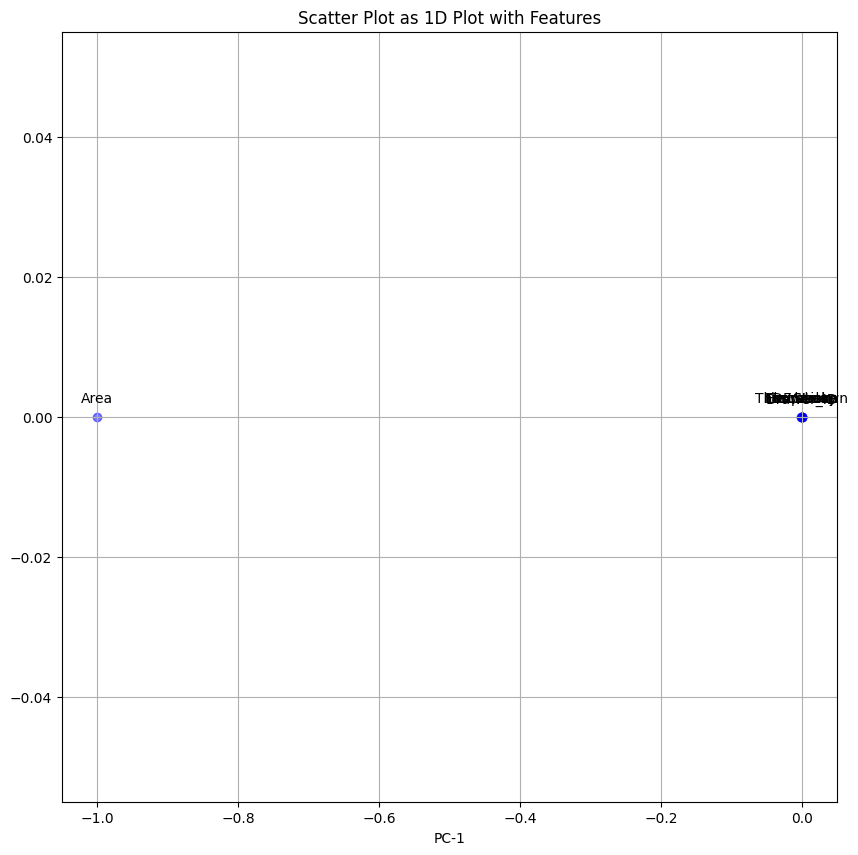

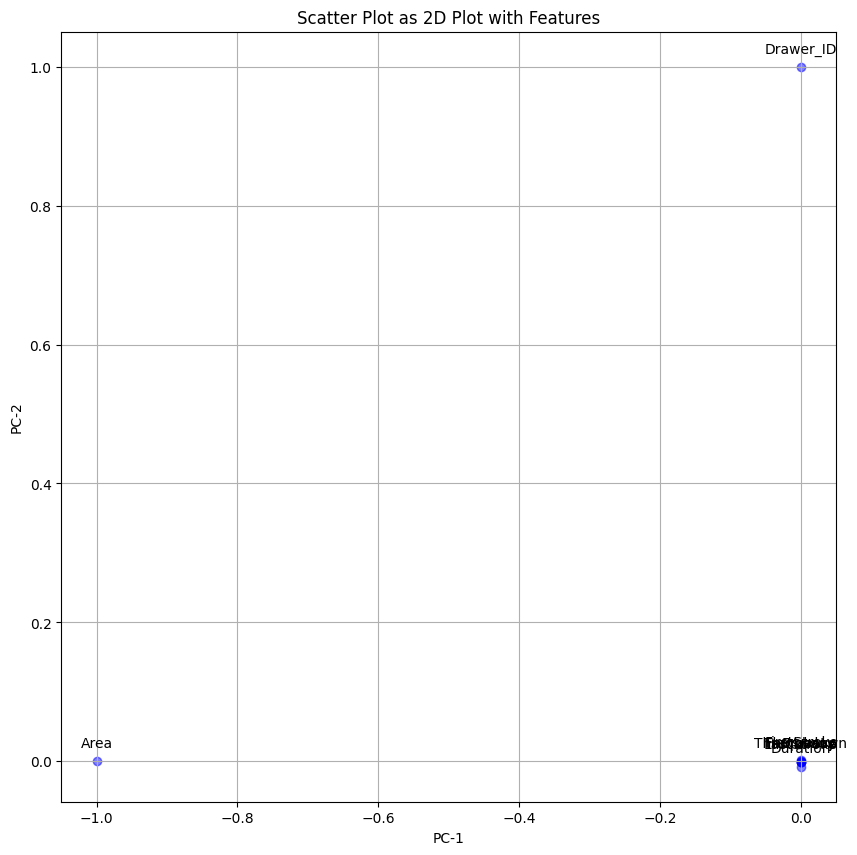

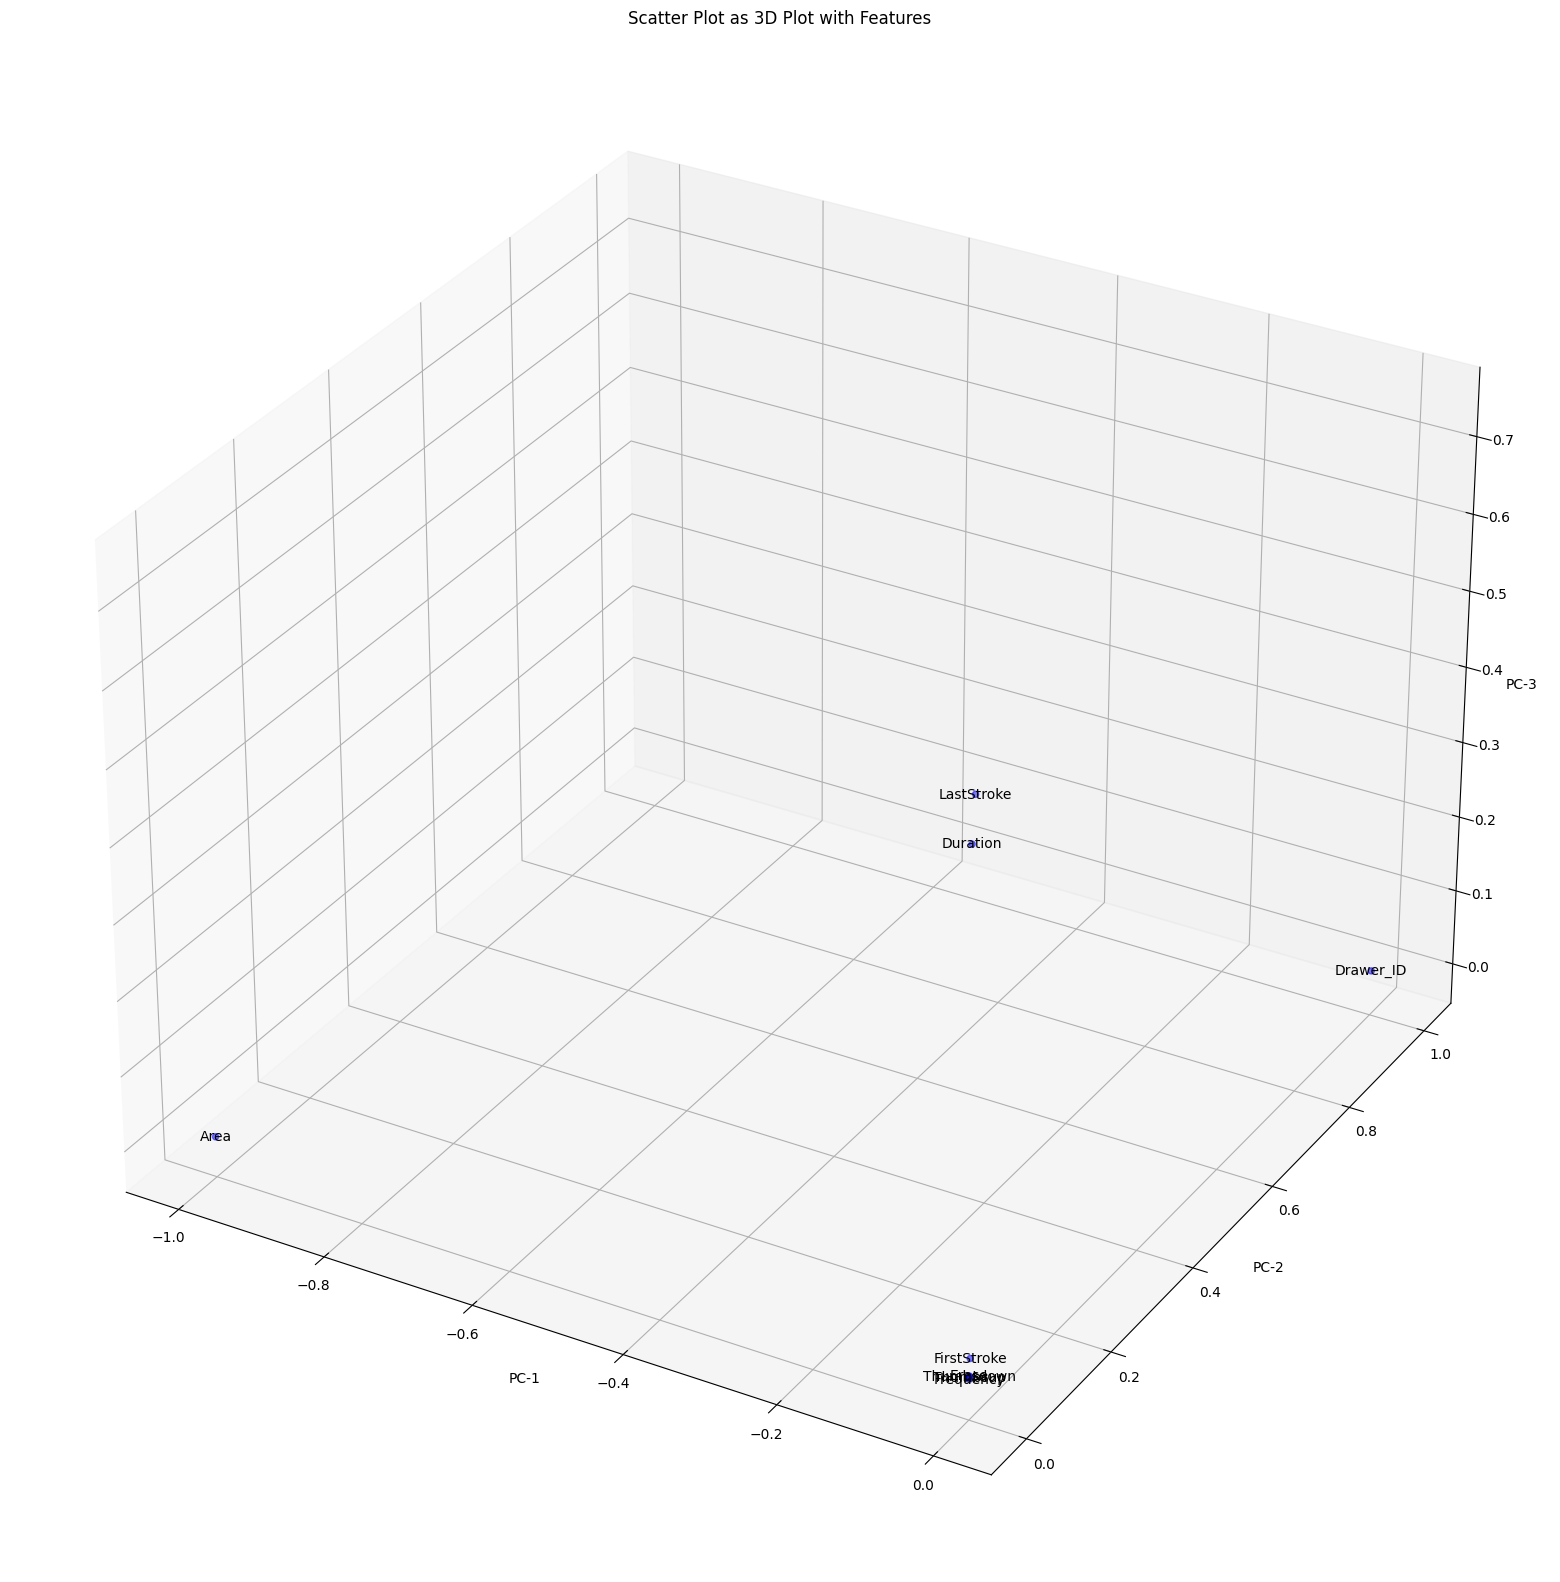

In [ ]:
# PC1 plot for Drawing Data 
x_coordinates = pca_draw.components_[:, 0]  # X-coordinates

# Create a Scatter Plot as the 1D data
plt.figure(figsize=(10, 10))
plt.scatter(x_coordinates, [0] * len(x_coordinates), marker='o', color='blue', alpha=0.5)

# Annotate points with their names, adjusting label positions to avoid overlap
for i, (x, name) in enumerate(zip(x_coordinates, features_draw)):
    plt.annotate(name, (x, 0), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

# Customize the plot
plt.xlabel('PC-1')
plt.title('Scatter Plot as 1D Plot with Features')
plt.grid(True)

# Show the plot
plt.show()

# PC1 vs. PC2 plot for Drawing Data
y_coordinates = pca_draw.components_[:, 1] # Y-coordinates

# Create a Scatter Plot as the 2D data
plt.figure(figsize=(10, 10))
plt.scatter(x_coordinates, y_coordinates, marker='o', color='blue', alpha=0.5)

# Annotate points with their names, adjusting label positions to avoid overlap
for x, y, name in zip(x_coordinates, y_coordinates, features_draw):
    plt.annotate(name, (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

# Customize the plot
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('Scatter Plot as 2D Plot with Features')
plt.grid(True)

# Show the plot
plt.show()

z_coordinates = pca_draw.components_[:, 2] # Y-coordinates
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the points
scatter = ax.scatter(x_coordinates, y_coordinates, z_coordinates, marker='o', c='blue',alpha=0.5)

# Annotate points with their names
for x, y, z, name in zip(x_coordinates, y_coordinates, z_coordinates, features_draw):
    ax.text(x, y, z, name, fontsize=10, ha='center', va='center')

# Customize the plot
ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')
ax.set_title('Scatter Plot as 3D Plot with Features')
ax.grid(True)

# Show the plot
plt.show()

# Scatter Plot as Guesser Data

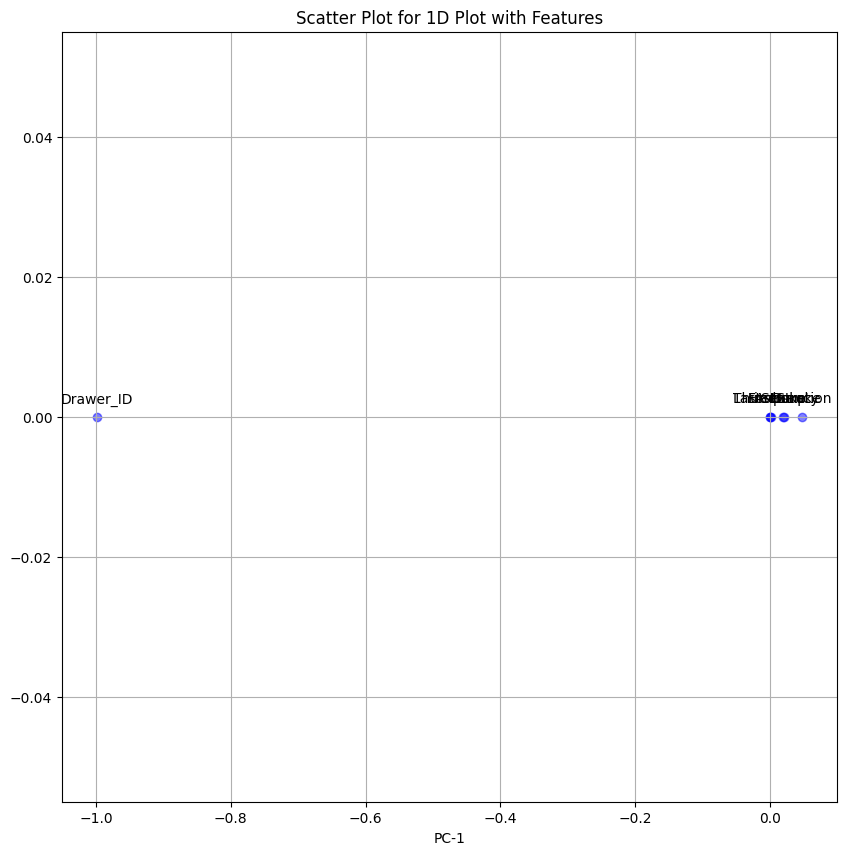

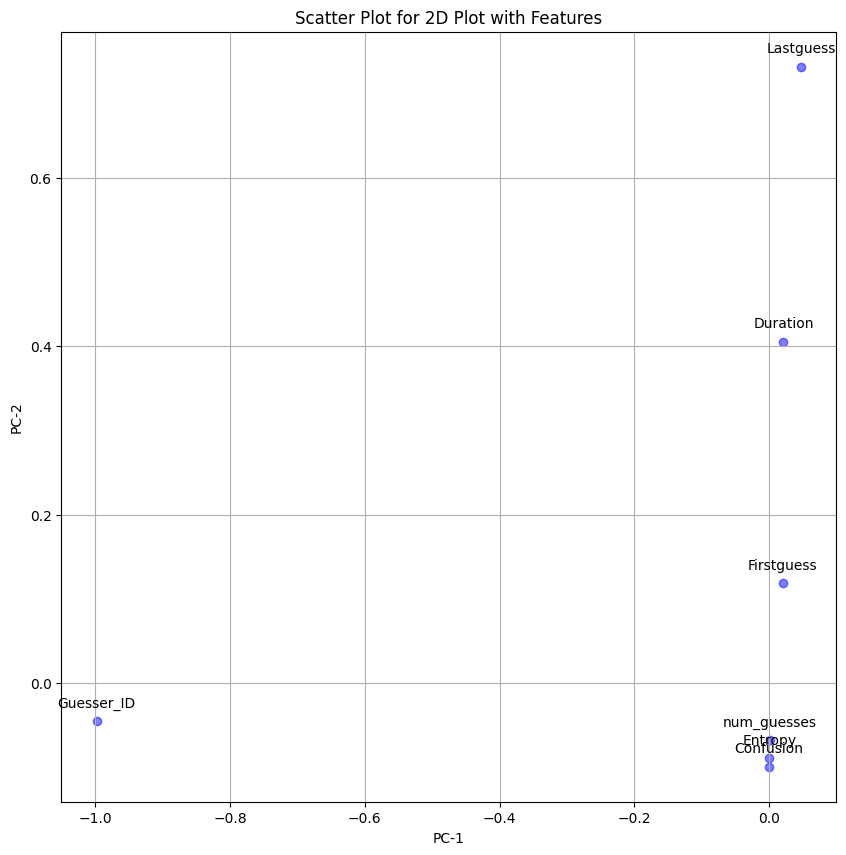

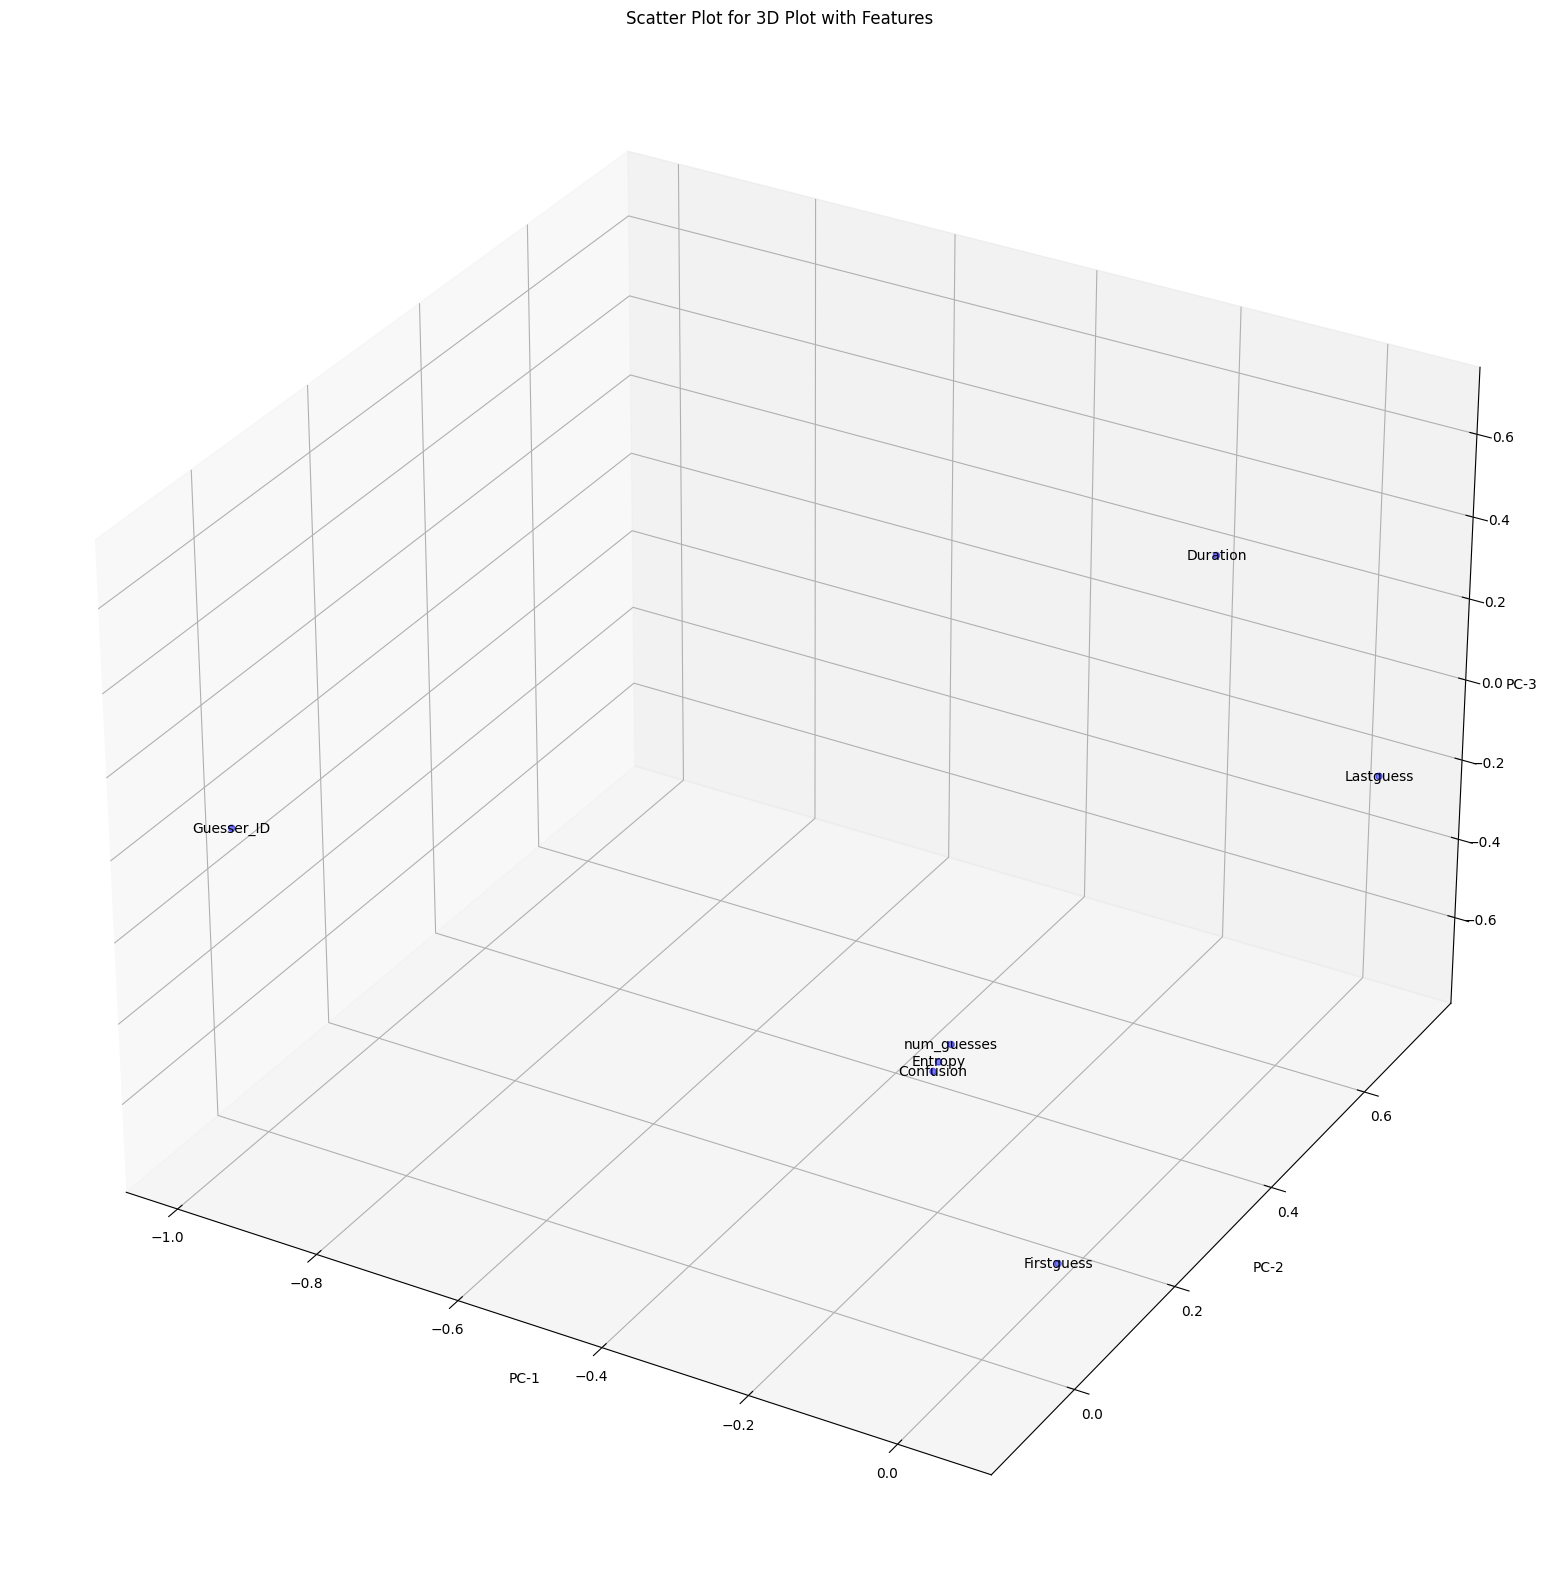

In [ ]:
# PC1 plot for Guessing Data 
x_coordinates = pca_guess.components_[:, 0]  # X-coordinates

# Create a Scatter Plot as the 1D data
plt.figure(figsize=(10, 10))
plt.scatter(x_coordinates, [0] * len(x_coordinates), marker='o', color='blue', alpha=0.5)

# Annotate points with their names, adjusting label positions to avoid overlap
for i, (x, name) in enumerate(zip(x_coordinates, features_draw)):
    plt.annotate(name, (x, 0), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

# Customize the plot
plt.xlabel('PC-1')
plt.title('Scatter Plot as 1D Plot with Features')
plt.grid(True)

# Show the plot
plt.show()

# PC1 vs. PC2 plot for Guessing Data
y_coordinates = pca_guess.components_[:, 1] - 0.1 # Y-coordinates

# Create a Scatter Plot as the 2D data
plt.figure(figsize=(10, 10))
plt.scatter(x_coordinates, y_coordinates, marker='o', color='blue', alpha=0.5)

# Annotate points with their names, adjusting label positions to avoid overlap
for x, y, name in zip(x_coordinates, y_coordinates, features_guess):
    plt.annotate(name, (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

# Customize the plot
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('Scatter Plot as 2D Plot with Features')
plt.grid(True)

# Show the plot
plt.show()

z_coordinates = pca_guess.components_[:, 2] # Y-coordinates
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the points
scatter = ax.scatter(x_coordinates, y_coordinates, z_coordinates, marker='o', c='blue', alpha=0.5)

# Annotate points with their names
for x, y, z, name in zip(x_coordinates, y_coordinates, z_coordinates, features_guess):
    ax.text(x, y, z, name, fontsize=10, ha='center', va='center')

# Customize the plot
ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')
ax.set_title('Scatter Plot as 3D Plot with Features')
ax.grid(True)

# Show the plot
plt.show()